#Time Series Stock Price Forecasting using a Prophet Model
* Data is collected from [Yahoo Finance](https://finance.yahoo.com/) using the yfinance package

1.) Imports

In [103]:
#Import required packages
import os
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

2.) Working Directory

In [105]:
#Check the current working directory
print("Current working directory:", os.getcwd())

#Set the working directory
os.chdir('C:/Users/ambue/OneDrive/Documents/Working_Directory')  #Replace with your own desired path
print("New working directory:", os.getcwd())

Current working directory: C:\Users\ambue\OneDrive\Documents\Working_Directory
New working directory: C:\Users\ambue\OneDrive\Documents\Working_Directory


3.) Data Collection

In [107]:
#Pull historical stock data from Yahoo Finance
ticker = "NAT" #Change ticker to desired stock
data = yf.download(ticker, start="2021-01-01", end="2025-01-31")  #Adjust dates as needed (Ideally use at least 3 years historical data)

[*********************100%***********************]  1 of 1 completed


4.) Data Preprocessing

In [109]:
#Reset MultiIndex columns
data.columns = data.columns.get_level_values(0)  #Use only the top-level column names

#Prepare data for Prophet (the Prophet package expects a df with two columns: 'ds' for date and 'y' for the target)
prophet_data = data[['Close']].reset_index()
prophet_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

#Ensure the 'y' column is numeric and handle missing values
prophet_data = prophet_data.dropna(subset=['y'])
prophet_data['y'] = pd.to_numeric(prophet_data['y'], errors='coerce')
prophet_data = prophet_data.dropna(subset=['y'])

5.)Train Test Split

In [111]:
#Split into training and test sets
cutoff = int(len(prophet_data) * 0.8)  #80% training, 20% test
train = prophet_data[:cutoff]
test = prophet_data[cutoff:]

6.) Model Training

In [113]:
#Train the Prophet Model
model = Prophet(changepoint_prior_scale=0.01)
model.fit(train)

20:23:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:52 - cmdstanpy - INFO - Chain [1] done processing


7.) Forecasting

In [115]:
#Make future predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

#Bound the forecast to 0 (if any predicted values are less than 0, set them to 0)
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, 0))  #For point forecasts
forecast['yhat_lower'] = forecast['yhat_lower'].apply(lambda x: max(x, 0))  #Lower bound
forecast['yhat_upper'] = forecast['yhat_upper'].apply(lambda x: max(x, 0))  #Upper bound

8.) Model Evaluation

In [117]:
#Extract the test predictions
forecast_test = forecast[-len(test):]  #Match test set size

#Get actual and predicted values
actual_values = test['y'].values  #True prices
predicted_values = forecast_test['yhat'].values  #Forecasted prices

#Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

#Print evaluation metrics
print(f"Evaluation Metrics for {ticker}:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

Evaluation Metrics for NAT:
MAE: 1.1365
RMSE: 1.2910
MAPE: 36.78%


9.) Visualization

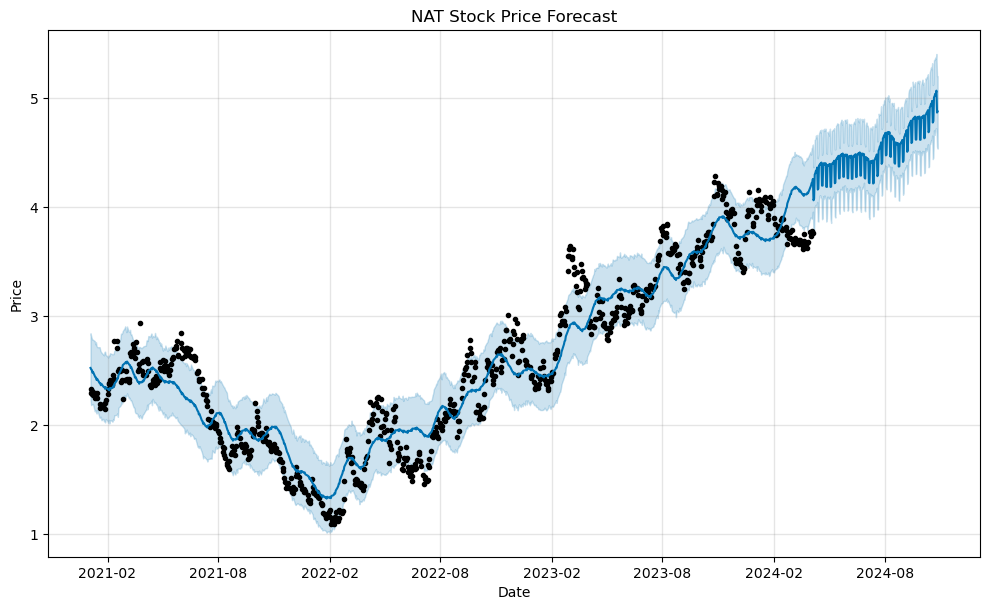

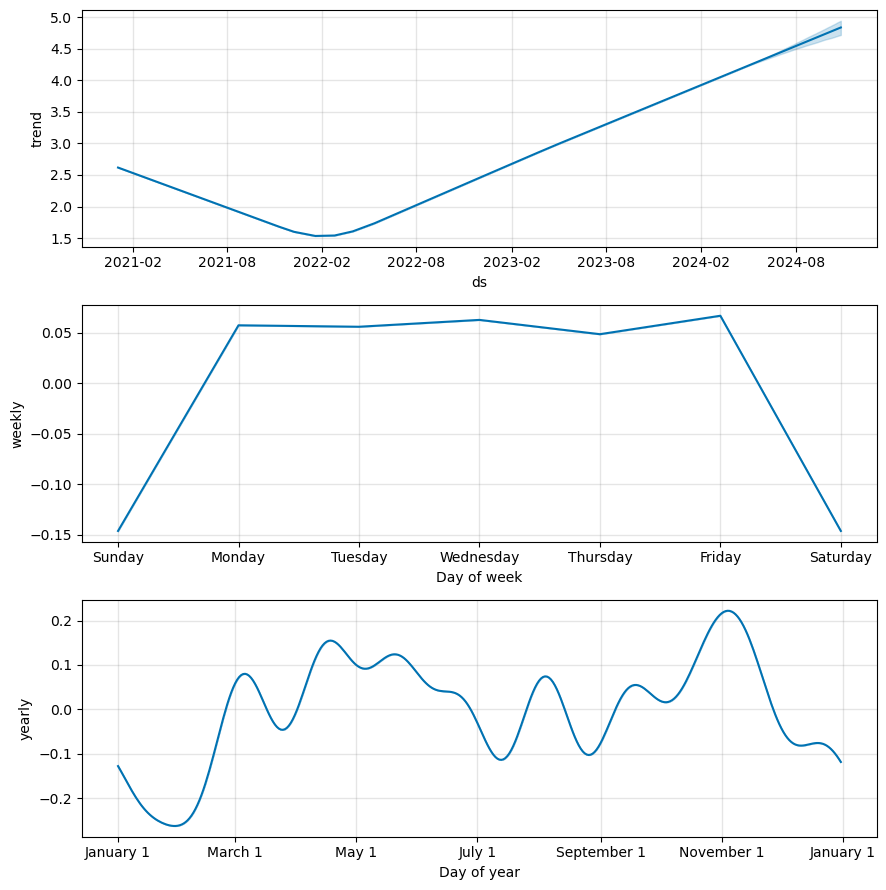

In [119]:
#Plot the forecast
fig1 = model.plot(forecast)
plt.title(f"{ticker} Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

#Plot forecast components
fig2 = model.plot_components(forecast)
plt.show()

10.) Export Results

In [121]:
#Save the forecast to a CSV
forecast.to_csv(f"{ticker}_forecast.csv", index=False)

#Print the forecast summary
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds      yhat  yhat_lower  yhat_upper
1019 2024-10-23  5.039833    4.701232    5.372613
1020 2024-10-24  5.038590    4.723130    5.364040
1021 2024-10-25  5.069332    4.720979    5.406754
1022 2024-10-26  4.868067    4.554108    5.203886
1023 2024-10-27  4.879374    4.537081    5.202460
